In [1]:
import pandas as pd
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

In [2]:
import pickle
from pprint import pprint
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve 

In [3]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


''

In [4]:
location = "/content/gdrive/My Drive/Colab Notebooks/MultiModal_PD/"

# **Loading and Intergrating Data**

---


In [5]:
df_biospec = pd.read_csv(location + "biospecimen_masterDB.csv", sep=",")

print(len(df_biospec))
print(len(df_biospec.columns))
df_biospec.head()

641
7


,PATNO,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,3915.0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,3914.0,614.150,1584.650,14.0825,174.325,270.285714,1
2,3838.0,746.900,1256.775,10.9825,137.050,234.571429,1
3,3819.0,612.020,1136.380,8.4880,109.100,231.875000,1
4,3900.0,511.280,1263.540,11.3980,145.260,400.666667,1


In [6]:
df_clinical = pd.read_csv(location + "clinical_masterDB.csv", sep=",")

df_clinical = df_clinical.drop(columns = ["ENROLLDT", "RAHAWOPI", "SLEEPINESS", "DEPRESSION", "RBD_STATUS",
                                          "GENDER", "HISPLAT", "RAINDALS", "RAASIAN", "RABLACK", "RAWHITE", "RANOS",
                                          "MDS_UPDRS1", "MDS_UPDRS2", "MDS_UPDRS3", "MOCA","Unadjusted_MOCA", "TREMOR", "PIGD"],
                               axis = 1)

print(len(df_clinical))
print(len(df_clinical.columns))
df_clinical.head()

682
31


,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,3000.0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,28.125,9.125000,0.917647,11.875000,0,0,0,0,0,2,6.125000,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,3001.0,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,26.875,10.125000,1.012658,15.125000,0,1,0,0,1,12,15.444444,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,3002.0,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,25.875,9.500000,1.012346,10.500000,0,0,0,1,2,11,24.555556,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,3003.0,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,26.125,11.375000,0.896552,9.125000,0,0,0,1,0,8,15.555556,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,3004.0,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,21.000,11.571429,0.750000,11.285714,0,0,0,0,1,3,6.571429,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [7]:
df_genetic = pd.read_csv(location + "snp_masterDB.csv", sep=",")

file = open(location + "feaSel_xgb.txt", "r")
retain_list = []
counter = 0
for line in file:
  counter +=1
  if(counter > 0):
    retain_list.append(line[:-1])

retain_list = retain_list[:30]
print("features =", len(retain_list))

all_columns = df_genetic.columns
drop_list = []
for i in all_columns:
  if(i not in retain_list and i != "STATUS" and i != "PATNO"):
    drop_list.append(i)

df_genetic = df_genetic.drop(columns = drop_list, axis = 1)
print(len(df_genetic))
print(len(df_genetic.columns))
df_genetic.head()

features = 30
733
32


,PATNO,chr4_90753960_C_T,chr4_90636708_T_C,chr4_90643757_C_G,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90671069_A_G,chr4_90678541_G_A,chr4_90711770_T_C,chr4_90727088_C_T,chr4_90730687_C_A,chr4_90737327_G_A,chr4_90741773_A_G,chr4_90754313_C_T,chr4_90755939_A_G,chr4_90763260_A_G,chr4_90763360_C_A,chr16_30995528_A_G,chr16_30995669_T_C,chr21_27348372_A_G,chr4_90697157_T_C,chr1_20977856_T_C,chr17_44091724_G_A,chr17_44101871_A_G,chr17_44102638_A_G,chr4_90697979_T_C,chr4_90755239_G_A,chr4_90683990_T_C,chr4_90742815_G_A,chr4_90744216_G_A,chr4_90752205_T_C,STATUS
0,3627,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3509,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,3214,0,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,3556,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3367,1,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
df = pd.merge(df_clinical, df_biospec, on="PATNO")
df = pd.merge(df, df_genetic, on="PATNO")

print(len(df))
print(len(df.columns))
df.head()

598
68


,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS_x,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS_y,chr4_90753960_C_T,chr4_90636708_T_C,chr4_90643757_C_G,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90671069_A_G,chr4_90678541_G_A,chr4_90711770_T_C,chr4_90727088_C_T,chr4_90730687_C_A,chr4_90737327_G_A,chr4_90741773_A_G,chr4_90754313_C_T,chr4_90755939_A_G,chr4_90763260_A_G,chr4_90763360_C_A,chr16_30995528_A_G,chr16_30995669_T_C,chr21_27348372_A_G,chr4_90697157_T_C,chr1_20977856_T_C,chr17_44091724_G_A,chr17_44101871_A_G,chr17_44102638_A_G,chr4_90697979_T_C,chr4_90755239_G_A,chr4_90683990_T_C,chr4_90742815_G_A,chr4_90744216_G_A,chr4_90752205_T_C,STATUS
0,3000.0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,28.125,9.125000,0.917647,11.875000,0,0,0,0,0,2,6.125000,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0,1078.833333,1728.766667,18.6500,217.800,275.250000,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0
1,3001.0,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,26.875,10.125000,1.012658,15.125000,0,1,0,0,1,12,15.444444,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1,987.280000,1412.600000,14.8580,174.420,278.600000,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1
2,3002.0,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,25.875,9.500000,1.012346,10.500000,0,0,0,1,2,11,24.555556,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1,553.600000,2667.400000,30.4725,318.400,215.200000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
3,3003.0,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,26.125,11.375000,0.896552,9.125000,0,0,0,1,0,8,15.555556,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1,753.640000,814.240000,8.9880,109.200,219.166667,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1
4,3004.0,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,21.000,11.571429,0.750000,11.285714,0,0,0,0,1,3,6.571429,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0,898.875000,1014.775000,10.2075,116.795,423.600000,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0


In [9]:
df = df.drop(columns = ["PATNO", "STATUS_x", "STATUS_y"], axis = 1)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,ABETA42,A_SYN,P_TAU,T_TAU,URATE,chr4_90753960_C_T,chr4_90636708_T_C,chr4_90643757_C_G,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90671069_A_G,chr4_90678541_G_A,chr4_90711770_T_C,chr4_90727088_C_T,chr4_90730687_C_A,chr4_90737327_G_A,chr4_90741773_A_G,chr4_90754313_C_T,chr4_90755939_A_G,chr4_90763260_A_G,chr4_90763360_C_A,chr16_30995528_A_G,chr16_30995669_T_C,chr21_27348372_A_G,chr4_90697157_T_C,chr1_20977856_T_C,chr17_44091724_G_A,chr17_44101871_A_G,chr17_44102638_A_G,chr4_90697979_T_C,chr4_90755239_G_A,chr4_90683990_T_C,chr4_90742815_G_A,chr4_90744216_G_A,chr4_90752205_T_C,STATUS
0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,28.125,9.125000,0.917647,11.875000,0,0,0,0,0,2,6.125000,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,1078.833333,1728.766667,18.6500,217.800,275.250000,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0
1,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,26.875,10.125000,1.012658,15.125000,0,1,0,0,1,12,15.444444,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,987.280000,1412.600000,14.8580,174.420,278.600000,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1
2,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,25.875,9.500000,1.012346,10.500000,0,0,0,1,2,11,24.555556,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,553.600000,2667.400000,30.4725,318.400,215.200000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
3,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,26.125,11.375000,0.896552,9.125000,0,0,0,1,0,8,15.555556,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,753.640000,814.240000,8.9880,109.200,219.166667,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1
4,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,21.000,11.571429,0.750000,11.285714,0,0,0,0,1,3,6.571429,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,898.875000,1014.775000,10.2075,116.795,423.600000,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0


# **XGBoost Feature Selection**

---

In [10]:
print(len(df))
print(len(df.columns))

input_columns=len(df.columns)-1
output_columns=1

X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

598
65


43
UPSIT                 0.094811
SCOPA_GASTRO          0.067680
chr4_90755939_A_G     0.050003
chr4_90646886_G_A     0.049105
SCOPA_TOTAL           0.048685
SCOPA_CARDIO          0.039982
chr4_90697157_T_C     0.035474
chr4_90697979_T_C     0.034329
GDS                   0.031020
First_Fam_PD          0.028282
chr4_90753960_C_T     0.028086
SCOPA_THERMO          0.023658
chr4_90711770_T_C     0.023209
P_TAU                 0.022592
chr4_90649290_C_G     0.021083
RBDSQ                 0.020657
URATE                 0.020190
T_TAU                 0.020047
ABETA42               0.019230
A_SYN                 0.018939
STAI                  0.018280
AGE                   0.017056
chr4_90741773_A_G     0.016999
SCOPA_PUPIL           0.016879
LNS                   0.016024
First_Fam_Num         0.015977
Other_Fam_PD          0.015597
chr4_90763260_A_G     0.015220
chr4_90737327_G_A     0.014945
HVLT_RECOG            0.014515
SFT                   0.013695
ESS                   0.013465
chr4_

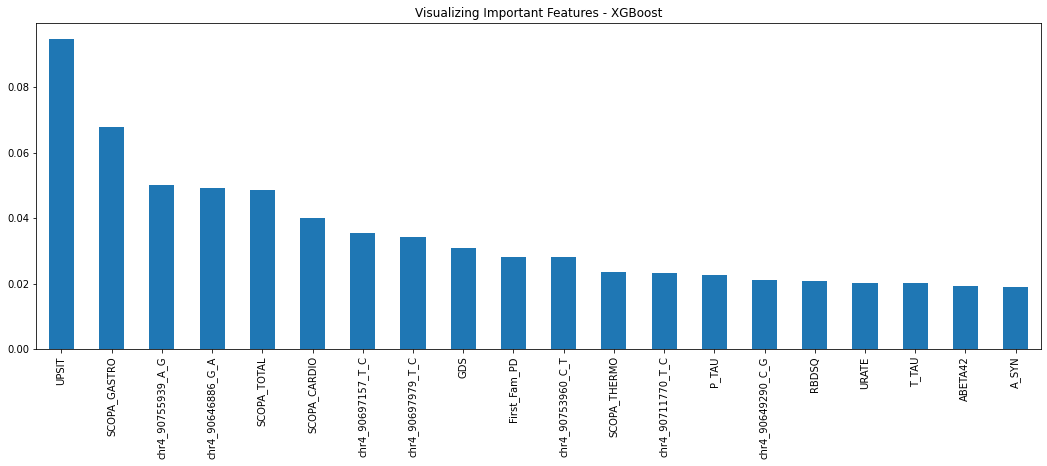

In [11]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

(feature_imp.sort_values(ascending=False).head(20)).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

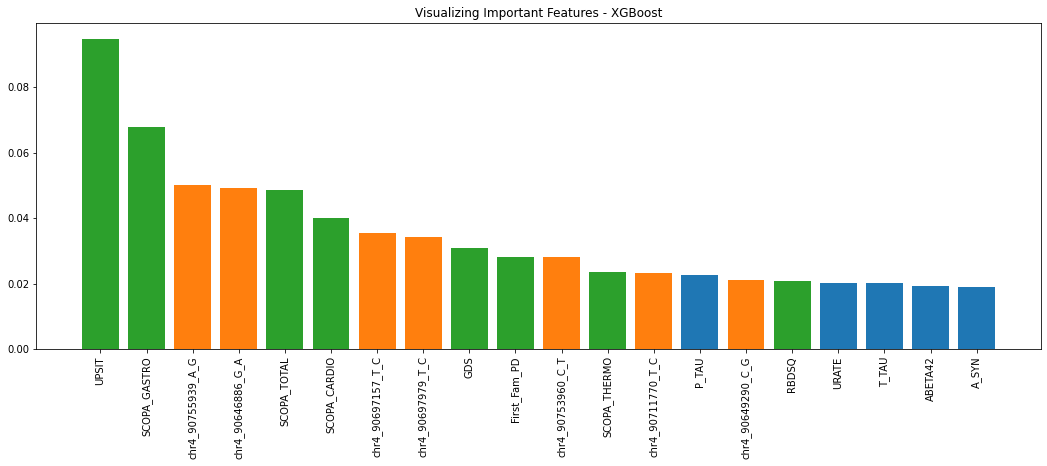

In [25]:
temp = feature_imp.sort_values(ascending=False).head(20)

score = temp.values
x = temp.index


c = "tab:green"
b = "tab:blue"
g = "tab:orange"
colors_list = list([c,c,g,g,c,c,g,g,c,c,g,c,g,b,g,c,b,b,b,b])

plt.figure(figsize=(18,6))
plt.bar(x, score, color=colors_list)
plt.xticks(rotation = 90)
plt.title("Visualizing Important Features - XGBoost")
plt.show()

# **ML Models**

---


In [368]:
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))
print(len(df.columns))

input_columns = len(df.columns)-1
output_columns = 1

598
65


In [ ]:
path = location + "shuffled_df_early.csv"
df.to_csv(path, index=False)

In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

478 120


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

Train Data distribtuion:
PD    340
HC    138
Name: STATUS, dtype: int64


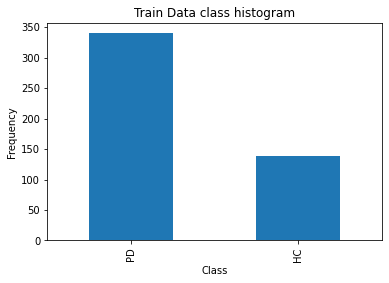

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
PD    87
HC    33
Name: STATUS, dtype: int64


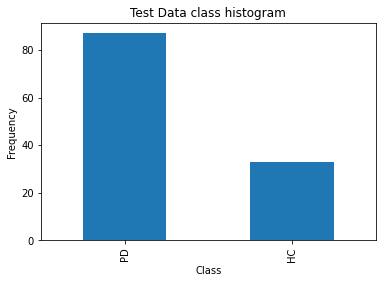

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

In [ ]:
scalarX = MinMaxScaler() # Normalising
scalarX.fit(X)

X = scalarX.transform(X)
X_test = scalarX.transform(X_test)

## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.8,0.99, 50)


# specify parameters and distributions to sample from
hp = {
    'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      # 'n_estimators': [10, 25], 
      # 'max_features': [5, 10], 
      # 'max_depth': [10, 50, None], 
      'max_depth': np.arange(1, 40, 1),
      'max_features': ['auto', 'sqrt', 'log2', 5, 10, 12, 15, 17, 18, 20, 23, 25],
      # 'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      # 'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(150, 300, 50),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_RF' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  5.1min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 0.9706122448979592,
                                     1: 0.029387755102040836},
                       criterion='entropy', max_depth=11, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=True)
{'bootstrap': False,
 'class_weight': {0: 0.9706122448979592, 1: 0.029387755102040836},
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 15,
 'n_estimators': 200,
 'warm_start': True}

Saving model



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


AUC-ROC =  0.9393939393939394
AUC-PR =  0.9795787368406754
F1 score =  0.9230769230769231
Precision =  0.9512195121951219
Recall =  0.896551724137931
              precision    recall  f1-score   support

           0       0.76      0.88      0.82        33
           1       0.95      0.90      0.92        87

    accuracy                           0.89       120
   macro avg       0.86      0.89      0.87       120
weighted avg       0.90      0.89      0.89       120



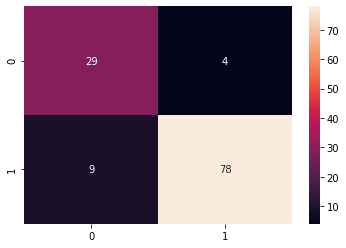

In [ ]:
# load the model from disk
filename = location + 'early_RF' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

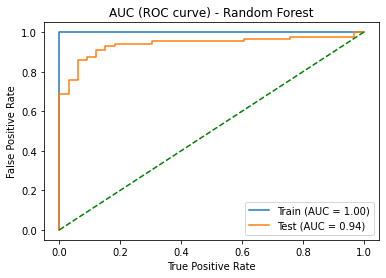

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()
 
# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())
 
# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=100)}
# pprint(hp)
 
# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)
 
#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)
 
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)
 
print("\nSaving model\n")
 
clf = random_search.best_estimator_
 
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)
 
# save the model to disk
filename = location + 'early_GNB_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 100 is smaller than n_iter=200. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GaussianNB(priors=None, var_smoothing=0.0003511191734215131)
{'var_smoothing': 0.0003511191734215131}

Saving model



[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


AUC-ROC =  0.896551724137931
AUC-PR =  0.9592326405303124
F1 score =  0.8079470198675496
Precision =  0.953125
Recall =  0.7011494252873564
              precision    recall  f1-score   support

           0       0.54      0.91      0.67        33
           1       0.95      0.70      0.81        87

    accuracy                           0.76       120
   macro avg       0.74      0.81      0.74       120
weighted avg       0.84      0.76      0.77       120



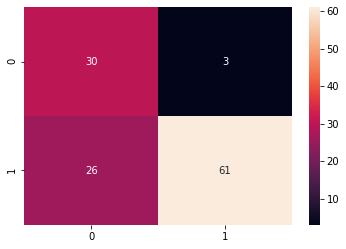

In [ ]:
# load the model from disk
filename = location + 'early_GNB_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

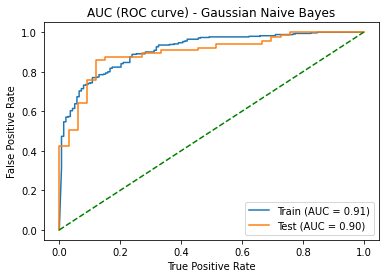

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_SVM' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   13.8s


SVC(C=95, break_ties=False, cache_size=200,
    class_weight={0: 0.9628571428571429, 1: 0.037142857142857144}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=0.001, verbose=False)
{'C': 95,
 'class_weight': {0: 0.9628571428571429, 1: 0.037142857142857144},
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'linear',
 'shrinking': False}

Saving model



[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   17.3s finished


AUC-ROC =  0.9216300940438872
AUC-PR =  0.9761214360352292
F1 score =  0.9268292682926829
Precision =  0.987012987012987
Recall =  0.8735632183908046
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        33
           1       0.99      0.87      0.93        87

    accuracy                           0.90       120
   macro avg       0.87      0.92      0.88       120
weighted avg       0.92      0.90      0.90       120



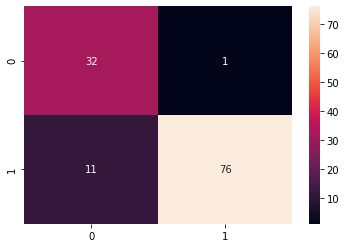

In [ ]:
# load the model from disk
filename = location + 'early_SVM_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=25, break_ties=False, cache_size=200,
    class_weight={0: 0.8077551020408164, 1: 0.19224489795918365}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


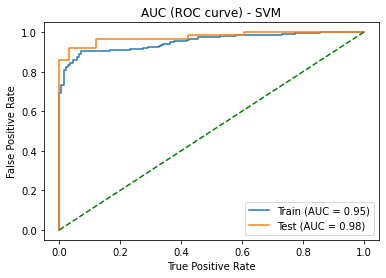

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'penalty': ['l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'multi_class': ['multinomial', 'ovr', 'auto'],
      'warm_start': [True, False],
      'l1_ratio': np.arange(0, 1.1, 0.1),
      'random_state': [81]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_logReg' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 4348 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 6940 tasks      | elapsed:  1.2min


LogisticRegression(C=10,
                   class_weight={0: 0.943469387755102, 1: 0.05653061224489797},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.4, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)
{'C': 10,
 'class_weight': {0: 0.943469387755102, 1: 0.05653061224489797},
 'l1_ratio': 0.4,
 'multi_class': 'auto',
 'penalty': 'l1',
 'random_state': 81,
 'solver': 'liblinear',
 'warm_start': False}

Saving model



[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  1.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


AUC-ROC =  0.9494949494949494
AUC-PR =  0.9794888259081541
F1 score =  0.8133333333333334
Precision =  0.9682539682539683
Recall =  0.7011494252873564
              precision    recall  f1-score   support

           0       0.54      0.94      0.69        33
           1       0.97      0.70      0.81        87

    accuracy                           0.77       120
   macro avg       0.76      0.82      0.75       120
weighted avg       0.85      0.77      0.78       120



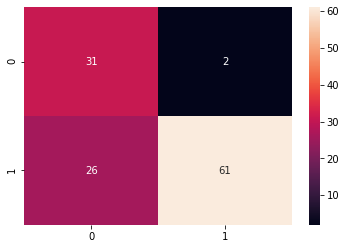

In [ ]:
# load the model from disk
filename = location + 'early_logReg' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_logReg = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=10,
                   class_weight={0: 0.943469387755102, 1: 0.05653061224489797},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.4, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)


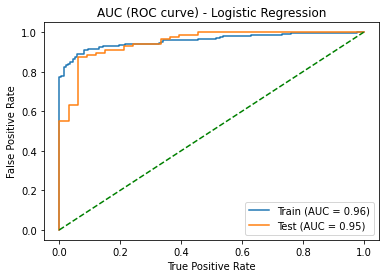

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **Stochastic Gradient Descent**

---

In [ ]:
clf = SGDClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'alpha': [0.0001, 0.001, 0.01, 0.1,0.15,0.2,0.5,0.8,1],
      'l1_ratio': [0,0.1,0.15,0.18,0.2,0.3],
      'loss': ['log'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'random_state': [81],
      'tol': [None]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 300
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_SGD_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.4min finished


SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.8155102040816327, 1: 0.18448979591836734},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)
{'alpha': 0.0001,
 'class_weight': {0: 0.8155102040816327, 1: 0.18448979591836734},
 'l1_ratio': 0.3,
 'loss': 'log',
 'random_state': 81,
 'tol': None}

Saving model



AUC-ROC =  0.9272030651340996
AUC-PR =  0.9687756614317432
F1 score =  0.9101796407185629
Precision =  0.95
Recall =  0.8735632183908046
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        33
           1       0.95      0.87      0.91        87

    accuracy                           0.88       120
   macro avg       0.84      0.88      0.85       120
weighted avg       0.89      0.88      0.88       120



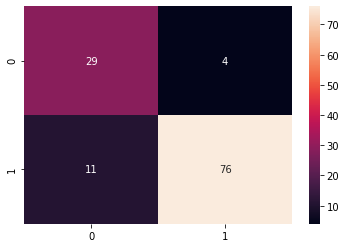

In [ ]:
# load the model from disk
filename = location + 'early_SGD_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_SGD = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.8155102040816327, 1: 0.18448979591836734},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)


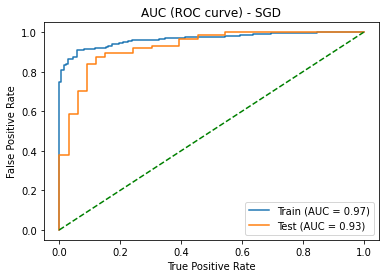

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SGD")
plt.show()

## **ROC Curve**

---

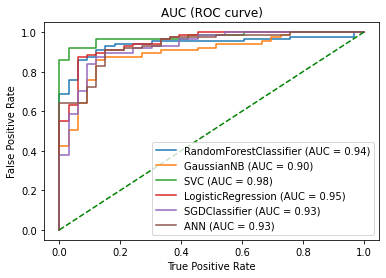

In [ ]:
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_SGD]

for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)
plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()

# **ANN**

---

In [ ]:
# # Load XGBoost Features
# file = open(location + "feaSel_xgb.txt", "r")
# retain_list = []
# counter = 0
# for line in file:
#   counter +=1
#   if(counter > 0):
#     retain_list.append(line[:-1])

# print(len(retain_list))

93


In [ ]:
# # Retain only XGBoost Features
# retain_list = retain_list[:10]

# all_columns = df.columns
# drop_list = []
# for i in all_columns:
#   if(i not in retain_list and i != "STATUS" and i.startswith("chr") == True):
#     drop_list.append(i)

# df = df.drop(columns = drop_list, axis = 1)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,ABETA42,A_SYN,P_TAU,T_TAU,URATE,chr4_90753960_C_T,chr4_90649290_C_G,chr4_90671069_A_G,chr4_90678541_G_A,chr4_90711770_T_C,chr4_90741773_A_G,chr4_90754313_C_T,chr16_30995528_A_G,chr1_20977856_T_C,chr4_90697979_T_C,STATUS
0,3.0,0.0,4.0,0.0,71,10.0,8.500000,2.8,1.200000,16.500000,8.250000,0.346154,3.000000,0,0,0,0,0,3,7.200000,3.200000,2.200000,0.000000,1.400000,0.4,0.000000,20.500000,51.400000,14.0,1067.300,1900.333333,18.1200,195.733333,302.000000,1,1,1,1,1,1,1,1,0,0,1
1,8.0,0.0,12.0,0.0,68,16.0,13.800000,5.5,1.166667,23.600000,9.000000,0.645833,8.000000,0,0,1,0,0,6,18.666667,6.333333,4.833333,1.666667,2.666667,1.0,2.166667,49.800000,47.166667,30.0,1104.950,2179.100000,20.6000,259.350000,222.000000,1,1,1,1,1,1,1,1,0,0,1
2,10.0,0.0,9.0,0.0,57,12.0,13.142857,8.0,0.857143,24.571429,11.571429,0.945205,10.428571,0,0,0,1,1,4,5.857143,1.142857,3.857143,0.000000,0.000000,0.0,0.857143,45.714286,50.428571,37.5,1138.825,1722.100000,15.6775,178.925000,383.200000,1,1,0,0,1,1,1,1,0,0,0
3,7.0,0.0,8.0,0.0,55,16.0,14.200000,4.6,0.600000,27.600000,11.000000,1.037736,11.000000,0,0,0,0,0,5,9.600000,3.000000,3.000000,0.800000,1.600000,0.0,1.200000,45.800000,43.600000,35.0,853.200,1185.300000,10.6800,128.750000,235.600000,0,1,1,1,0,1,1,1,0,1,0
4,7.0,0.0,12.0,0.0,65,16.0,12.625000,7.8,1.500000,16.750000,8.875000,0.727273,6.500000,0,1,0,0,0,6,4.200000,0.300000,3.700000,0.000000,0.100000,0.1,0.000000,25.875000,61.100000,24.0,1379.000,2193.900000,16.3600,206.100000,258.428571,1,1,1,1,1,1,1,1,1,0,1


In [ ]:
print(len(df))
print(len(df.columns))

input_columns = len(df.columns)-1
output_columns = 1

598
65


#### **Defining Train_data, Val_data and Test data**

---

In [ ]:
dataset = df.values

train_length = int(0.6*len(df))
val_length = int(0.2*len(df))+1
test_length = int(0.2*len(df))+1

X1 = dataset[:train_length,0:input_columns]
y1 = dataset[:train_length, -1].reshape(train_length, 1)

X1_valid = dataset[train_length: (train_length + val_length), 0:input_columns]
y1_valid = dataset[train_length: (train_length + val_length), -1].reshape(val_length, 1)

X1_test = dataset[(train_length + val_length): (train_length + val_length + test_length), 0:input_columns]
y1_test = dataset[(train_length + val_length): (train_length + val_length + test_length), -1].reshape(test_length, 1)

# USING CLASS WEIGHTS
class_weights = dict(zip(np.unique(y1.flatten()), class_weight.compute_class_weight('balanced', np.unique(y1.flatten()), y1.flatten())))

scalarX = MinMaxScaler()
scalarX.fit(X1)

X1 = scalarX.transform(X1)
X1_valid = scalarX.transform(X1_valid)
X1_test = scalarX.transform(X1_test)

print(len(X1), len(X1_valid), len(X1_test))
print(len(X1[0]), len(X1_valid[0]), len(X1_test[0]))

358 120 120
64 64 64


Train Data distribtuion:
PD    252
HC    106
Name: STATUS, dtype: int64


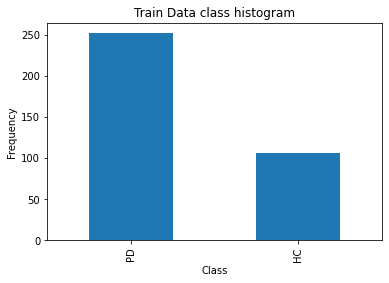

In [ ]:
# Train data distribution
count_classes = df.iloc[:train_length, -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Val Data distribtuion:
PD    88
HC    32
Name: STATUS, dtype: int64


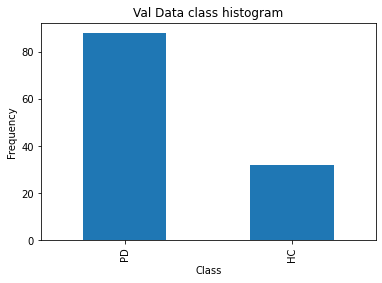

In [ ]:
# Val data distribution
count_classes = df.iloc[train_length: (train_length + val_length), -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Val Data distribtuion:")
print(count_classes)
plt.title("Val Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
1    87
0    33
Name: STATUS, dtype: int64


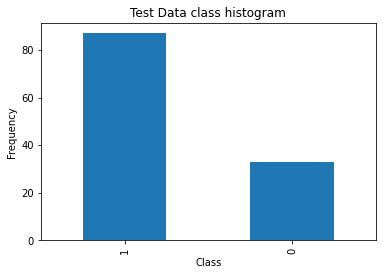

In [ ]:
# Test data distribution
count_classes = df.iloc[(train_length + val_length): (train_length + val_length + test_length), -1].value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

In [ ]:
model = Sequential()
model.add(Dense(2, input_dim=input_columns, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(4, activation='relu'))
model.add(Dense(output_columns, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 5
num_epoch = 100
output = model.fit(X1, y1, batch_size = batch_size, epochs=num_epoch, verbose=1,
                   class_weight=class_weights, validation_data=(X1_valid, y1_valid))

Epoch 1/100
72/72 [==============================] - 1s 3ms/step - loss: 0.9080 - val_loss: 0.7031
Epoch 2/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7595 - val_loss: 0.7251
Epoch 3/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6971 - val_loss: 0.7382
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6961 - val_loss: 0.7197
Epoch 5/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6884 - val_loss: 0.7194
Epoch 6/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6755 - val_loss: 0.7105
Epoch 7/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6585 - val_loss: 0.7069
Epoch 8/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6453 - val_loss: 0.6995
Epoch 9/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6708 - val_loss: 0.6977
Epoch 10/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6441 - val_loss: 0.6955
Epoch 11/

<Figure size 432x288 with 0 Axes>

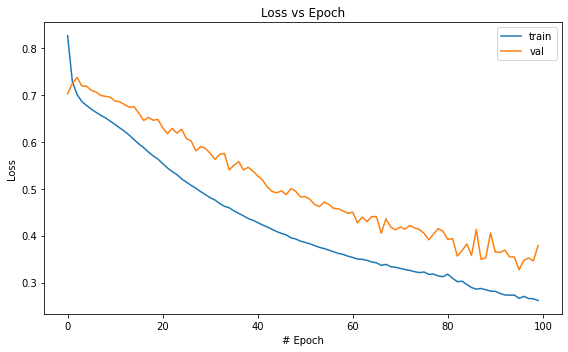

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8,5))
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('# Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()

### **Save Model**

In [ ]:
# Saving the model
print("\nSaving model")
# serialize model to JSON
model_json = model.to_json()
with open(location + "early_ann.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model as json")
# serialize weights to HDF5
model.save_weights(location + "early_ann_wt.h5")
print("Saved model weights")


Saving model
Saved model as json
Saved model weights


### **Load Model**

In [ ]:
print("\nLoading Model")
# load json and create model
path = location + "early_ann.json" 
json_file = open(path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
path = location + "early_ann_wt.h5" 
loaded_model.load_weights(path)
print("Loaded model from disk")

# evaluate loaded model on test data
print("\nEvaluating Model")
loaded_model.compile(loss='binary_crossentropy', optimizer='adam')
score = loaded_model.evaluate(X1_valid, y1_valid, verbose=1)
print("Evaluated Model")
print("%s: %f" % (loaded_model.metrics_names[0], score))


Loading Model
Loaded model from disk

Evaluating Model
4/4 [==============================] - 0s 2ms/step - loss: 0.3519
Evaluated Model
loss: 0.344305


In [ ]:
model = loaded_model

# **Model Evaluation**

---

Train AUC-ROC = 0.96
Validation AUC-ROC = 0.94
Test AUC-ROC = 0.93


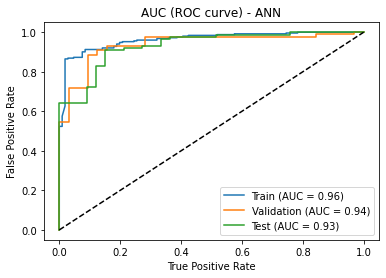

In [ ]:
pred = model.predict(X1)
# train_y_pred = np.where(pred > 0.5, 1, 0)
fpr_train, tpr_train, _ = roc_curve(y1, pred)
auc_train = auc(fpr_train, tpr_train).round(2)
print("Train AUC-ROC =", str(auc_train))

pred = model.predict(X1_valid)
# val_y_pred = np.where(pred > 0.5, 1, 0)
fpr_val, tpr_val, _ = roc_curve(y1_valid, pred)
auc_val = auc(fpr_val, tpr_val).round(2)
print("Validation AUC-ROC =", str(auc_val))

pred = model.predict(X1_test)
# test_y_pred = np.where(pred > 0.5, 1, 0)
fpr_test, tpr_test, _ = roc_curve(y1_test, pred)
auc_test = auc(fpr_test, tpr_test).round(2)
print("Test AUC-ROC =", str(auc_test))

plt.plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(auc_val))
plt.plot(fpr_test, tpr_test, label='Test (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - ANN")
plt.show()

In [ ]:
def check_metrics(model, testX, testY):  

  pred = model.predict(testX)
  y_pred = np.where(pred > 0.5, 1, 0)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(testY, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  print(classification_report(testY, y_pred))

In [ ]:
check_metrics(model, X1_test, y1_test)

##############  Confusion Matrix  ##############

[[28  5]
 [13 74]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.68      0.85      0.76        33
         1.0       0.94      0.85      0.89        87

    accuracy                           0.85       120
   macro avg       0.81      0.85      0.82       120
weighted avg       0.87      0.85      0.85       120



In [ ]:
check_metrics(model, X1_valid, y1_valid)

##############  Confusion Matrix  ##############

[[27  3]
 [13 77]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.68      0.90      0.77        30
         1.0       0.96      0.86      0.91        90

    accuracy                           0.87       120
   macro avg       0.82      0.88      0.84       120
weighted avg       0.89      0.87      0.87       120



In [ ]:
check_metrics(model, X1, y1)

##############  Confusion Matrix  ##############

[[100   3]
 [ 29 226]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86       103
         1.0       0.99      0.89      0.93       255

    accuracy                           0.91       358
   macro avg       0.88      0.93      0.90       358
weighted avg       0.93      0.91      0.91       358

